In [1]:
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import torch


def format_number(data_value, indx):
    if data_value >= 1_000_000:
        formatter = '{:1.1f}M'.format(data_value*0.000_001)
    else:
        formatter = '{:1.0f}k'.format(data_value*0.001)
    return formatter



num_layers = [1, 2, 3, 4, 5]


# run_paths = [
#     "logs/runs/2022-09-14/12-59-08",
#     "logs/runs/2022-09-14/13-00-21",
#     "logs/runs/2022-09-14/13-01-50",
#     "logs/runs/2022-09-14/13-05-06",
#     "logs/runs/2022-09-14/13-14-54",
# ]
# splits = [
#     [0, 9-1],
#     [0, 288, 321-1],
#     [0, 288, 1344, 1377-1],
#     [0, 288, 1344, 2400, 2433-1],
#     [0, 288, 1344, 2400, 3456, 3489-1],
# ]

run_paths = [
    "logs/multiruns/2022-09-19_10-13-50/0",
    "logs/multiruns/2022-09-19_10-16-30/0",
    "logs/multiruns/2022-09-19_10-25-03/0",
    "logs/multiruns/2022-09-19_10-31-20/0",
    "logs/multiruns/2022-09-19_10-37-52/0",
]
splits = [
    [0, 9-1],
    [0, 72, 81-1],
    [0, 72, 144, 153-1],
    [0, 72, 144, 216, 225-1],
    [0, 72, 144, 216, 288, 297-1],
]


def visualize_hessians_diag(ax, hessian: np.ndarray, splits: List[int]):
    assert len(hessian.shape) == 1

    ax.plot(hessian)
    for i, s in enumerate(splits):
        ax.vlines(x=s, ymin=0, ymax=max(hessian), colors="slategrey", linestyles="--")
        # ax.annotate(f"Layer {i}", (s, max(hessian)), color="slategrey", fontsize=12, ha="center", va="bottom")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: format_number(x, pos)))



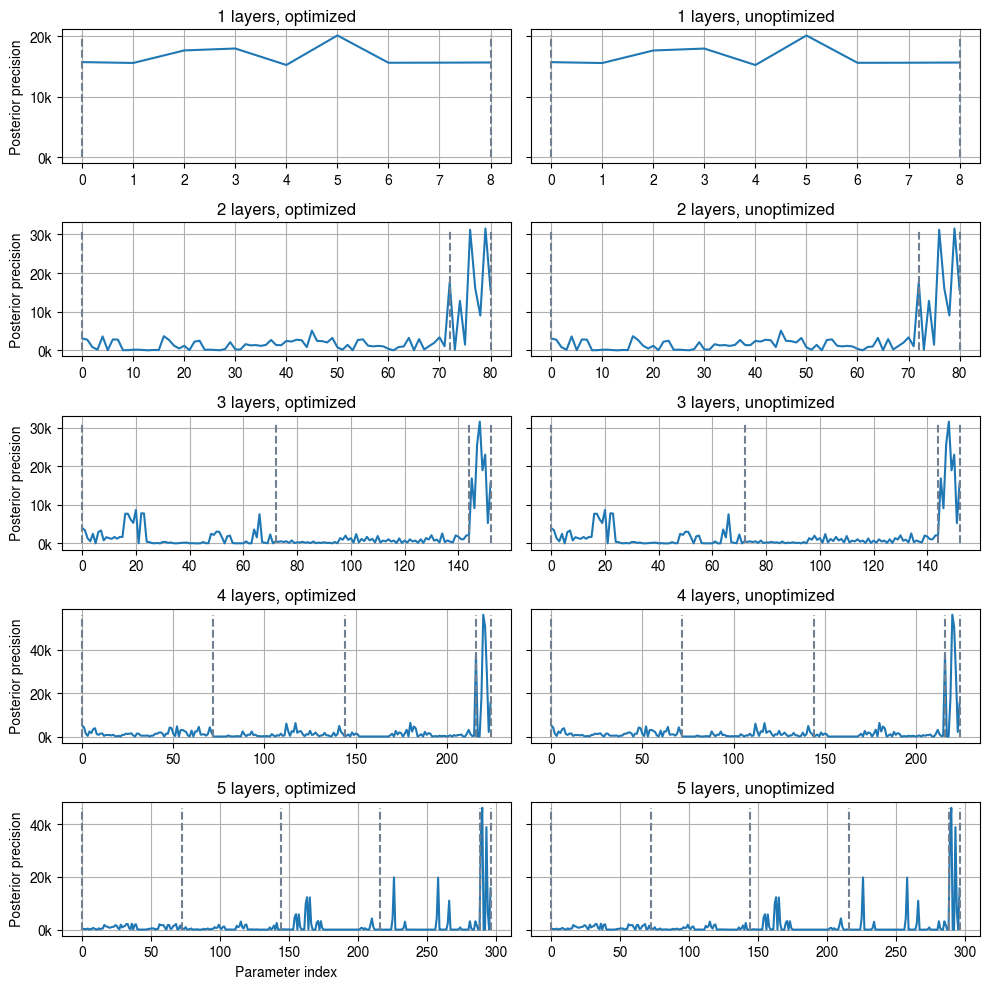

In [2]:
fig, ax = plt.subplots(nrows=5, ncols=2, sharey="row", figsize=(10, 10))
epoch = 2
struct = "diag"
for i, num_layer, run_path, split in zip(range(5), num_layers, run_paths, splits):
    posterior_precision_opt = torch.load(f"../{run_path}/posterior_precision_epoch{epoch}_opt_{struct}.pt").cpu().numpy()
    visualize_hessians_diag(ax[i, 0], posterior_precision_opt, split)

    posterior_precision_unopt = torch.load(f"../{run_path}/posterior_precision_epoch{epoch}_unopt_{struct}.pt").cpu().numpy()
    visualize_hessians_diag(ax[i, 1], posterior_precision_unopt, split)

    ax[i, 0].set_title(f"{i+1} layers, optimized")
    ax[i, 1].set_title(f"{i+1} layers, unoptimized")
    ax[i, 0].set_ylabel("Posterior precision")
ax[-1, 0].set_xlabel("Parameter index")
fig.tight_layout()

-33061.656


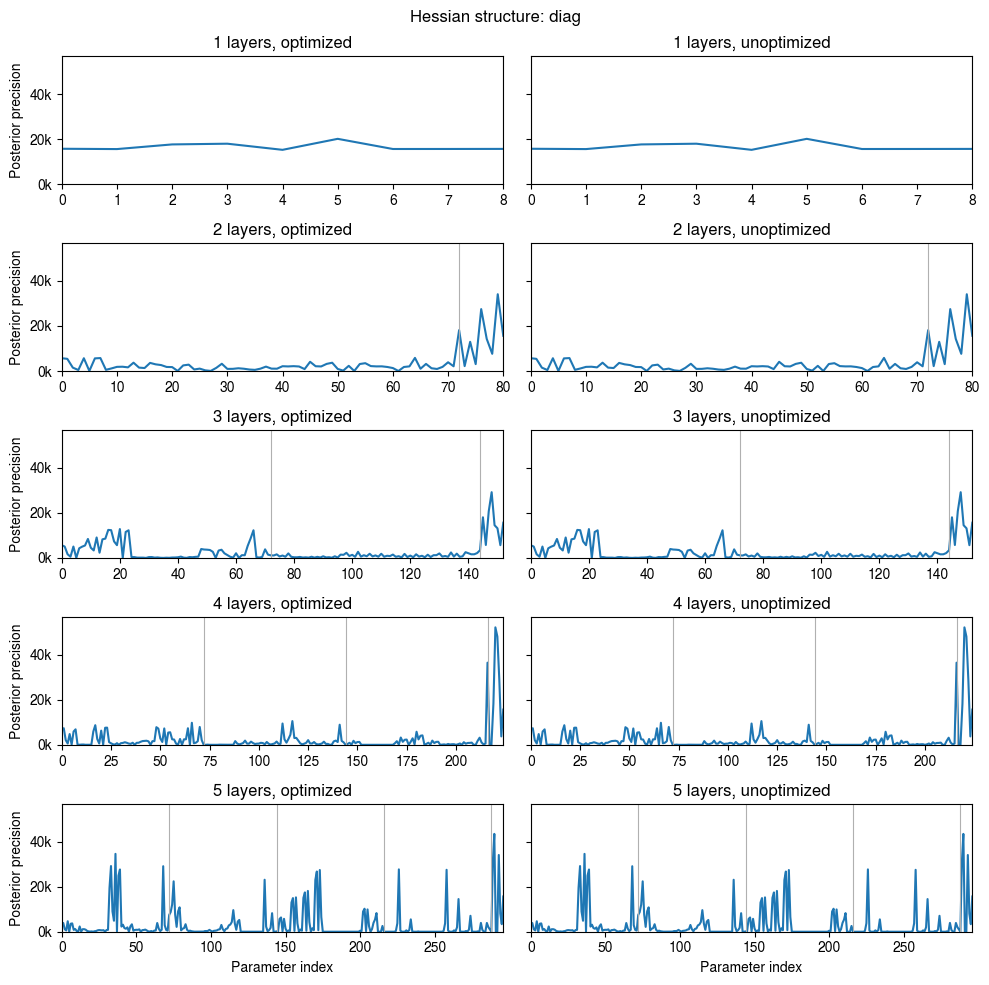

In [3]:
import matplotlib.animation as animation 
import matplotlib.pyplot as plt 
import numpy as np 
  

struct = "diag"
n_epochs = 10
   
# creating a blank window
# for the animation 
fig, axs = plt.subplots(nrows=5, ncols=2, sharey="row", figsize=(10, 10))

vmin = np.inf
vmax = -np.inf
for i in range(5):
    for j in range(n_epochs):
        posterior_precision = torch.load(f"../{run_paths[i]}/posterior_precision_epoch{j}_opt_full.pt").cpu().numpy()
        vmin = min(vmin, posterior_precision.min())
        vmax = max(vmax, posterior_precision.max())
        posterior_precision = torch.load(f"../{run_paths[i]}/posterior_precision_epoch{j}_unopt_full.pt").cpu().numpy()
        vmin = min(vmin, posterior_precision.min())
        vmax = max(vmax, posterior_precision.max())

# vmin = min(vmin, 0)
print(vmin)
vmin = 0

def init_plots(axs):
    lines = []
    for i, ax in enumerate(axs):
        ax_opt, ax_unopt = ax

        lines.append(ax_opt.plot([], [])[0])
        ax_opt.set_title(f"{i+1} layers, optimized")
        ax_opt.set_ylabel("Posterior precision")
        ax_opt.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: format_number(x, pos)))

        lines.append(ax_unopt.plot([], [])[0])
        ax_unopt.set_title(f"{i+1} layers, unoptimized")
        ax_unopt.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: format_number(x, pos)))

        for j, s in enumerate(splits[i]):
            ax_opt.vlines(x=s, ymin=vmin, ymax=vmax, colors="#b0b0b0", linestyles="-", linewidth=0.8)
            ax_unopt.vlines(x=s, ymin=vmin, ymax=vmax, colors="#b0b0b0", linestyles="-", linewidth=0.8)
        ax_opt.set_xlim(0, max(splits[i]))
        ax_unopt.set_xlim(0, max(splits[i]))
        ax_opt.set_ylim(vmin, vmax)
        ax_unopt.set_ylim(vmin, vmax)
        ax_opt.grid(False)
        ax_unopt.grid(False)
    
    axs[-1][0].set_xlabel("Parameter index")
    axs[-1][1].set_xlabel("Parameter index")
    return lines
lines = init_plots(axs)
fig.suptitle(f"Hessian structure: {struct}")
fig.tight_layout()

# what will our line dataset
# contain?
def init():
    # line.set_data([], []) 
    # return line, 
    [line.set_data([], []) for line in lines]
    return lines


# animation function 
def animate(i):
    for j in range(5):

        posterior_precision = torch.load(f"../{run_paths[j]}/posterior_precision_epoch{i}_opt_{struct}.pt").cpu().numpy()
        lines[2*j].set_data(np.arange(posterior_precision.shape[0]), posterior_precision)

        posterior_precision = torch.load(f"../{run_paths[j]}/posterior_precision_epoch{i}_unopt_{struct}.pt").cpu().numpy()
        lines[2*j+1].set_data(np.arange(posterior_precision.shape[0]), posterior_precision)
      
    return lines

# calling the animation function     
anim = animation.FuncAnimation(fig, animate, init_func = init, 
                               frames = n_epochs, interval = 1000, blit = True) 
   
# saves the animation in our desktop
anim.save('posterior_precision_diag.mp4', writer = 'ffmpeg', fps = 1)

In [4]:

# splits = [
#     [0-.5, 9-1+.5],
#     [0-.5, 288+.5, 321-1+.5],
#     [0-.5, 288+.5, 1344+.5, 1377-1+.5],
#     [0-.5, 288+.5, 1344+.5, 2400+.5, 2433-1+.5],
#     [0-.5, 288+.5, 1344+.5, 2400+.5, 3456+.5, 3489-1+.5],
# ]
splits = [
    [0-.5, 9-1+.5],
    [0-.5, 72+.5, 81-1+.5],
    [0-.5, 72+.5, 144+.5, 153-1+.5],
    [0-.5, 72+.5, 144+.5, 216+.5, 225-1+.5],
    [0-.5, 72+.5, 144+.5, 216+.5, 288+.5, 297-1+.5],
]


In [20]:


# fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(13, 4))

# vmin = np.inf
# vmax = -np.inf
# for i in range(5):
#     posterior_precision = torch.load(f"../{run_paths[i]}/posterior_precision_epoch9_opt_full.pt").cpu().numpy()
#     vmin = min(vmin, posterior_precision.min())
#     vmax = max(vmax, posterior_precision.max())
#     posterior_precision = torch.load(f"../{run_paths[i]}/posterior_precision_epoch9_unopt_full.pt").cpu().numpy()
#     vmin = min(vmin, posterior_precision.min())
#     vmax = max(vmax, posterior_precision.max())

# for i in range(5):
#     posterior_precision = torch.load(f"../{run_paths[i]}/posterior_precision_epoch7_opt_full.pt").cpu().numpy()
#     heatmap = ax[0, i].imshow(posterior_precision, cmap="magma", vmin=vmin, vmax=vmax)

#     posterior_precision = torch.load(f"../{run_paths[i]}/posterior_precision_epoch7_unopt_full.pt").cpu().numpy()
#     heatmap = ax[1, i].imshow(posterior_precision, cmap="magma", vmin=vmin, vmax=vmax)
    
#     ax[0, i].grid(False)
#     ax[0, i].vlines(x=splits[i], ymin=min(splits[i]), ymax=max(splits[i]), colors="#b0b0b0", linestyles="-", linewidth=0.8)
#     ax[0, i].hlines(y=splits[i], xmin=min(splits[i]), xmax=max(splits[i]), colors="#b0b0b0", linestyles="-", linewidth=0.8)
    
#     ax[1, i].grid(False)
#     ax[1, i].vlines(x=splits[i], ymin=min(splits[i]), ymax=max(splits[i]), colors="#b0b0b0", linestyles="-", linewidth=0.8)
#     ax[1, i].hlines(y=splits[i], xmin=min(splits[i]), xmax=max(splits[i]), colors="#b0b0b0", linestyles="-", linewidth=0.8)
# fig.colorbar(heatmap, ax=ax[:, i].ravel().tolist())
# fig.tight_layout
# fig.show()

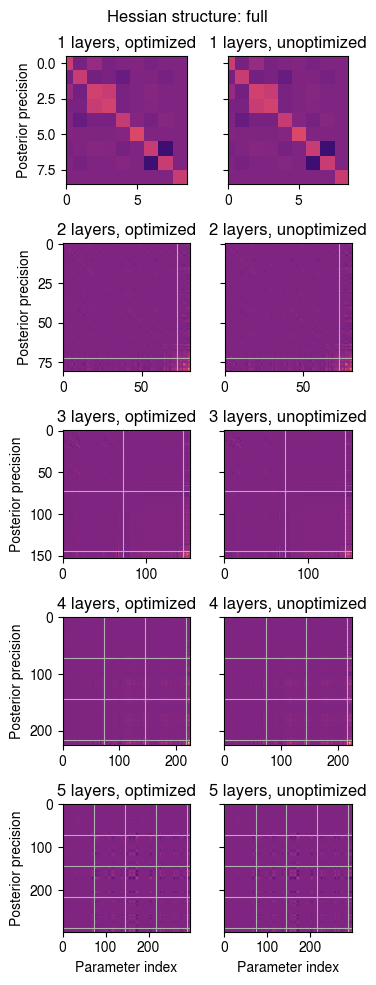

In [19]:
import matplotlib.animation as animation 
import matplotlib.pyplot as plt 
import numpy as np 

 
struct = "full"
n_epochs = 10
   
# creating a blank window
# for the animation 
fig, axs = plt.subplots(nrows=5, ncols=2, sharey="row", figsize=(4, 10))

vmin = np.inf
vmax = -np.inf
for i in range(5):
    for j in range(n_epochs):
        posterior_precision = torch.load(f"../{run_paths[i]}/posterior_precision_epoch{j}_opt_full.pt").cpu().numpy()
        vmin = min(vmin, posterior_precision.min())
        vmax = max(vmax, posterior_precision.max())
        posterior_precision = torch.load(f"../{run_paths[i]}/posterior_precision_epoch{j}_unopt_full.pt").cpu().numpy()
        vmin = min(vmin, posterior_precision.min())
        vmax = max(vmax, posterior_precision.max())

# vmin = 0

def init_plots(axs):
    lines = []
    for i, ax in enumerate(axs):
        ax_opt, ax_unopt = ax

        posterior_precision = torch.load(f"../{run_paths[i]}/posterior_precision_epoch0_opt_{struct}.pt").cpu().numpy()
        # n_params = int(splits[i][-1] + .5)

        lines.append(ax_opt.imshow(posterior_precision, cmap="magma", vmin=vmin, vmax=vmax))
        ax_opt.set_title(f"{i+1} layers, optimized")
        ax_opt.set_ylabel("Posterior precision")

        lines.append(ax_unopt.imshow(posterior_precision, cmap="magma", vmin=vmin, vmax=vmax))
        ax_unopt.set_title(f"{i+1} layers, unoptimized")

        ax_opt.vlines(x=splits[i], ymin=min(splits[i]), ymax=max(splits[i]), colors="#b0b0b0", linestyles="-", linewidth=0.8)
        ax_opt.hlines(y=splits[i], xmin=min(splits[i]), xmax=max(splits[i]), colors="#b0b0b0", linestyles="-", linewidth=0.8)
        
        ax_unopt.vlines(x=splits[i], ymin=min(splits[i]), ymax=max(splits[i]), colors="#b0b0b0", linestyles="-", linewidth=0.8)
        ax_unopt.hlines(y=splits[i], xmin=min(splits[i]), xmax=max(splits[i]), colors="#b0b0b0", linestyles="-", linewidth=0.8)

        ax_opt.set_xlim(0, max(splits[i]))
        ax_unopt.set_xlim(0, max(splits[i]))
        ax_opt.grid(False)
        ax_unopt.grid(False)
    
    axs[-1][0].set_xlabel("Parameter index")
    axs[-1][1].set_xlabel("Parameter index")
    return lines
lines = init_plots(axs)
fig.suptitle(f"Hessian structure: {struct}")
fig.tight_layout()

# what will our line dataset
# contain?
def init():
    [line.set_data([[0,0],[0,0]]) for line in lines]
    return lines

# animation function 
def animate(i):
    for j in range(5):
        posterior_precision = torch.load(f"../{run_paths[j]}/posterior_precision_epoch{i}_opt_{struct}.pt").cpu().numpy()
        lines[2*j].set_data(posterior_precision)
        # lines[2*j] = axs[j, 0].imshow(posterior_precision, cmap="magma", vmin=vmin, vmax=vmax)
        # lines[2*j].autoscale()

        posterior_precision = torch.load(f"../{run_paths[j]}/posterior_precision_epoch{i}_unopt_{struct}.pt").cpu().numpy()
        lines[2*j+1].set_data(posterior_precision)
        # lines[2*j + 1] = axs[j, 1].imshow(posterior_precision, cmap="magma", vmin=vmin, vmax=vmax)
        # lines[2*j+1].autoscale()
      
    return lines

# fig.colorbar(lines[-1], ax=axs[0, :].ravel().tolist(), orientation='horizontal')
fig.tight_layout()

# calling the animation function     
anim = animation.FuncAnimation(fig, animate, init_func = init, 
                               frames = n_epochs, interval = 1000, blit = True) 
   
# saves the animation in our desktop
anim.save('posterior_precision_full.mp4', writer = 'ffmpeg', fps = 1)